<a id="top"></a>
# Visualize Cutouts of Cloud Images
***
## Learning Goals

By the end of this tutorial, you will:

- Be able to query for observation products stored in STScI's public data bucket.
- Be able to create cutouts of FITS images using `astrocut.fits_cut()`.
- Be able to plot FITS cutouts


## Introduction

Hubble, Kepler, TESS, and GALEX mission datasets are available on STScI's public data buckets. These datasets are capable of housing large telescope images that would otherwise take up a lot of space locally. `astroquery.mast` allows you to search for and download these images, but it would be useful to preview the image before downloading. Some of these images contain multiple targets and the entire image would not be necessary. `astrocut` allows you to make cutouts of the larger images before downloading. This notebook will show you how to preview and cutout images stored on the cloud.


The workflow for this notebook consists of:
* [Visualize Cloud Cutouts](#Visualize-Cloud-Cutouts)
    * [Query for Observations](#Query-for-Observations)
    * [Get Data Products](#Get-Data-Products)
    * [Get the S3 URI](#Get-the-S3-URI)
    * [Get the Cutouts](#Get-the-Cutouts)
    * [Plot the Image](#Plot-the-Image)
* [Verify with On-Premise](#Verify-with-On-Premise)
* [Future Functionality](#Future-Functionality)
* [Additional Resources](#Additional-Resources)

## Imports
This notebook uses [astroquery.mast.Observations](https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#) as a data source. Other imports include:
- *astrocut fits_cut* for creatings cutouts of FITS files
- *astropy.io fits* for accessing FITS files
- *astropy.wcs WCS* for setting the plot projection
- *astropy.coordinates SkyCoord* for fits_cut parameters
- *matplotlib.pyplot* for plotting data
- *matplotlib.colors SymLogNorm* for high visibility plot colors

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astrocut import fits_cut
from astroquery.mast import Observations

***

## Visualize Cloud Cutouts

### Query for Observations

Using `astroquery.mast` we can query for public image observations with `Observations.query_criteria`.

This format allows us to type in a target we want to query for (e.g. 'COMET-67P-CHURYUMOV-GER-UPDATE').

In [2]:
targname=input('Name your target: ')
obs = Observations.query_criteria(target_name=targname,
                                  calib_level=[3, 4],
                                  dataproduct_type='image',
                                  dataRights='public'
                                 )

Name your target:  COMET-67P-CHURYUMOV-GER-UPDATE


View the results of the query:

In [3]:
obs

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str3,str6,str7,str3,str5,str7,str30,str52,str9,float64,float64,str5,str14,int64,float64,float64,float64,float64,float64,str119,float64,str5,str2,int64,str2255,str34,str35,str6,bool,float64,str8,str9
science,HST,CALACS,ACS/WFC,HST,F606W,Optical,COMET-67P-CHURYUMOV-GER-UPDATE,COMET; COMET BEING ORBITED BY THE ROSETTA SPACECRAFT,jcz310020,181.1951662479,10.61763873491,image,"Hines, Dean C.",3,57440.648545289354,57440.67854447917,2028.0,470.0,720.0,Post-Perihelion Imaging Polarimetry of the 67P/Churyumov-Gerasimenko with ACS: Continued Support of the Rosetta Mission,57807.14247684,14261,GO,--,POLYGON -178.78785789 10.6300156 -178.79002701400105 10.630273230469328 -178.78990524 10.63087418 -178.7920746146427 10.631131839607153 -178.79195285000003 10.63173274 -178.79412250230391 10.631990431771642 -178.79400075 10.63259127 -178.8222723 10.6359479 -178.82796798000004 10.60782453 -178.82579827554704 10.60756703292523 -178.82591999 10.60696599 -178.82375055730893 10.60670852444226 -178.82387228 10.60610744 -178.82170310558371 10.60585000444982 -178.82182483999998 10.60524886 -178.79355606000001 10.60189274 -178.78785789 10.6300156 -178.78785789 10.6300156,mast:HST/product/jcz310021_drz.jpg,mast:HST/product/jcz310021_drz.fits,PUBLIC,True,nan,26086963,300633148
science,HST,CALACS,ACS/WFC,HST,F606W,Optical,COMET-67P-CHURYUMOV-GER-UPDATE,COMET; COMET BEING ORBITED BY THE ROSETTA SPACECRAFT,jcz304010,166.8573512368,12.44607302407,image,"Hines, Dean C.",3,57336.02195381944,57336.05141678241,1868.0,470.0,720.0,Post-Perihelion Imaging Polarimetry of the 67P/Churyumov-Gerasimenko with ACS: Continued Support of the Rosetta Mission,57702.18168981,14261,GO,--,POLYGON 166.89033891 12.44822631 166.88674897167522 12.449774126201021 166.886962 12.45016215 166.8824647939837 12.452101045153221 166.88255106 12.45225818 166.85632954 12.4635612 166.855695250478 12.462405603434535 166.85116646 12.46435742 166.83729568 12.43908285 166.86351554 12.42778167 166.86385054235734 12.428392040911923 166.87646523 12.4229537 166.89033891 12.44822631 166.89033891 12.44822631,mast:HST/product/jcz304010_drz.jpg,mast:HST/product/jcz304010_drz.fits,PUBLIC,True,nan,25007223,300634655
science,HST,CALACS,ACS/WFC,HST,F606W,Optical,COMET-67P-CHURYUMOV-GER-UPDATE,COMET; COMET BEING ORBITED BY THE ROSETTA SPACECRAFT,jcz305010,167.3875248249,12.27638654269,image,"Hines, Dean C.",3,57337.082678356484,57337.11213457176,1868.0,470.0,720.0,Post-Perihelion Imaging Polarimetry of the 67P/Churyumov-Gerasimenko with ACS: Continued Support of the Rosetta Mission,57703.3171991,14261,GO,--,POLYGON 167.42033057 12.2785822 167.41678948221735 12.28011067424552 167.41700455 12.28050264 167.41255703425642 12.282422283760864 167.41264544 12.28258341 167.38645309 12.2938866 167.38582164337151 12.292735516548467 167.3813478 12.29466584 167.3674907 12.26940172 167.39368142 12.2581003 167.39400941977672 12.25869825568763 167.40647064 12.25332001 167.42033057 12.2785822 167.42033057 12.2785822,mast:HST/product/jcz305010_drz.jpg,mast:HST/product/jcz305010_drz.fits,PUBLIC,True,nan,25007224,300634685
science,HST,CALACS,ACS/WFC,HST,F606W,Optical,COMET-67P-CHURYUMOV-GER-UPDATE,COMET; COMET BEING ORBITED BY THE ROSETTA SPACECRAFT,jcz306010,167.8786138309,12.11906578756,image,"Hines, Dean C.",3,57338.0775628125,57338.10701863426,1868.0,470.0,720.0,Post-Perihelion Imaging Polarimetry of the 67P/Churyumov-Gerasimenko with ACS: Continued Support of the Rosetta Mission,57704.21634257,14261,GO,--,POLYGON 167.91083269 12.12255799 167.90721185049091 12.12386186530097 167.90751154 12.12450242 167.90296125663926 12.126140910540823 167.90314968 12.12654366 167.87627643 1

### Get Data Products 

Here, we'll iterate through our observations until we retrieve a list of related products using `Observations.get_product_list`. Then, using `Observations.filter_products`, we'll filter the product list to return image products with full FITS images. The extensions "drz.fits", "drc.fits", and "ffi.fits" will give us that.

In [4]:
dataprod = Observations.get_product_list(obs[0])
fits_products = Observations.filter_products(dataprod,
                                             dataproduct_type = 'image',
                                             extension = ["drz.fits", "drc.fits", "ffi.fits"])
idx = 0
for i in range(1, len(obs)):
    if len(fits_products) > 0:
        break
    dataprod = Observations.get_product_list(obs[i])
    fits_products = Observations.filter_products(dataprod,
                                                 dataproduct_type = 'image',
                                                 extension = ["drz.fits", "drc.fits", "ffi.fits"])
    idx = i

View the returned FITS products:

In [5]:
fits_products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str3,str5,str9,str62,str1,str40,str9,str28,str8,str1,str6,str20,str5,str23,int64,str8,str6,int64
26086963,HST,image,jcz310020,DADS DRZ file - Calibrated combined image ACS/WFC3/WFPC2/STIS,D,mast:HST/product/jcz310021_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,CALACS,DrizzlePac 3.6.1,14261,jcz310021_drz.fits,53786880,26086963,PUBLIC,3


### Get the S3 URI

To retrieve the URIs of the FITS products stored on the cloud, we must enable cloud data access using `Observations.enable_cloud_dataset`. We then input our list of FITS products into the `Observations.get_cloud_uris` method. This will iterate through the list of products, check if there is matching data on the cloud, and then return the locations as a list of URIs.

In [6]:
Observations.enable_cloud_dataset(provider='AWS')

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


Retrieve and view the list of S3 URIs:

In [7]:
s3_uris = Observations.get_cloud_uris(fits_products)
s3_uris = [uri for uri in s3_uris if uri is not None]
s3_uris

['s3://stpubdata/hst/public/jcz3/jcz310020/jcz310021_drz.fits']

Remember, not all observations exist on the cloud. If there are no URIs returned, try another target.

### Get the Cutouts

`astrocut.fits_cut` requires the list of URIs, center coordinates as a string or a SkyCoord object, and a cutout size. We can get the center coordinates using either the "s_ra" and "s_dec" columns from our `obs` table or the "s_region" column. The "s_region" column provides all the vertices of a target's regional polygon as a string. We will average these points to get coordinates closer to the center of the target for the cutout. 

In [8]:
region = obs[idx]["s_region"].replace("POLYGON ", "")
region_values = region.split(" ")
ra_avg = sum([float(region_values[i]) for i in range(0, len(region_values), 2)]) / (len(region_values) / 2)
dec_avg = sum([float(region_values[i]) for i in range(1, len(region_values), 2)]) / (len(region_values) / 2)
coords = "{} {}".format(ra_avg, dec_avg)
coords

'-178.80568455718816 10.620152972981414'

In [9]:
center_coord = SkyCoord(coords, unit='deg')
cutout_size = [500, 500]
cutout_file = fits_cut(s3_uris, center_coord, cutout_size, single_outfile=True)

### Plot the Data

We will use `fits.open` to open the file in memory. Make sure to keep your cutouts relatively small as to not overload your memory space.

In [10]:
with fits.open(cutout_file, fsspec_kwargs={"anon": True}) as hdul:
    header = hdul[1].header
    image = hdul[1].data

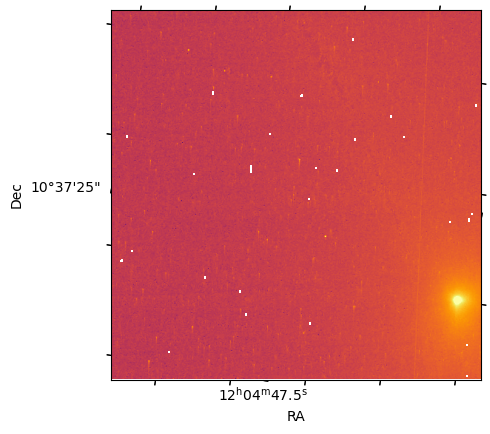

In [11]:
wcs_helix = WCS(header)
fig = plt.figure()
fig.add_subplot(111, projection=wcs_helix)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.imshow(image, cmap="inferno", origin='lower', norm=SymLogNorm(linthresh=0.03,vmin=0, vmax=1))

## Verify with On-Premise

Since we're switching from cloud data, we can now disable cloud access using `Observations.disable_cloud_dataset`. 

In [12]:
Observations.disable_cloud_dataset()

We can verify that the image preview we plotted from the cloud data is the same as on-premise, and download our cutout using `Observations.download_products`. Cloud products are downloaded using the "cloud_only" parameter. Its default is False, so we do not have to explicitly mention it here. 

In [13]:
result = Observations.download_products(fits_products)

INFO: Found cached file ./mastDownload/HST/jcz310020/jcz310021_drz.fits with expected size 53786880. [astroquery.query]


Our file will be downloaded locally, so we'll reference it using a local path.

In [14]:
file = result['Local Path'][0]

Using `astrocut.fits_cut` again we can create the same cutout of our downloaded file with the predefined center_coord and cutout_size. Make sure the images match. 

In [15]:
cutout_file = fits_cut(file, center_coord, cutout_size, single_outfile=True)

In [16]:
with fits.open(cutout_file, fsspec_kwargs={"anon": True}) as hdul:
    header = hdul[1].header
    image = hdul[1].data

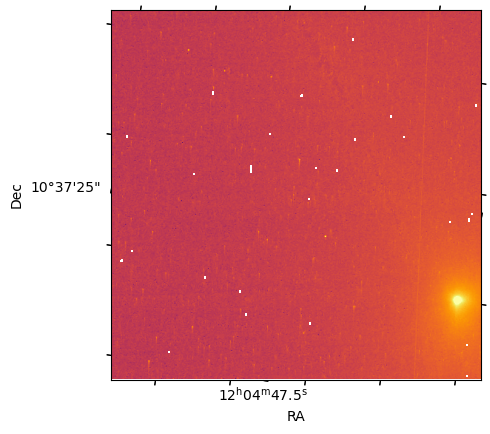

In [17]:
wcs_helix = WCS(header)
fig = plt.figure()
fig.add_subplot(111, projection=wcs_helix)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.imshow(image, cmap="inferno", origin='lower', norm=SymLogNorm(linthresh=0.03,vmin=0, vmax=1))

## Future Improvements

* Further generalization for mission compatibility
    * Missions other than HST do not return as many results.
    * Only some missions are available publically on the cloud.
* Functionality to center cutouts on targets
    * This notebook centers cutouts on the center point and not necessarily on the target.
    * Moving targets and clusters especially would benefit.
    * Make notebook more interactive so users can manually position cutouts.

## Additional Resources

Other notebooks and documentation for further understanding of this tutorial:

- [Observations Field Descriptions](https://mast.stsci.edu/api/v0/_c_a_o_mfields.html)
- [Astroquery Beginner Search](https://github.com/spacetelescope/mast_notebooks/blob/main/notebooks/astroquery/beginner_search/beginner_search.ipynb)
- [Astrocut Documentation](https://astrocut.readthedocs.io)

## Citations

If you use `astropy` or `astroquery` for published research, please cite the
authors. Follow these links for more information about citing:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION)


## About this Notebook

**Author(s):** Makayla St. Cyr <br>
**Keyword(s):** Tutorial, MAST, cloud, astroquery, astrocut <br>
**Last Updated:** Sept 2023 <br>
**Next Review:** Oct 2023
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 